# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [16]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

import numpy as np
import matplotlib.pyplot as plt
#下面的`scipy`是一个用于科学计算和技术计算的Python库，提供了许多高级的数学函数和便利的操作，包括数值积分、插值、优化、图像处理、统计等。
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）。
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。
from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
from mpl_toolkits.mplot3d import Axes3D #`mpl_toolkits.mplot3d`是`matplotlib`库的一个模块，用于创建三维图形。`Axes3D`是`mpl_toolkits.mplot3d`模块中的一个类，用于创建一个三维的坐标轴。可以在这个坐标轴上绘制三维的图形，如曲线、曲面等。
import time #一个内置模块，用于处理时间相关的操作。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。

import math
import pandas as pd #pandas用于处理结构化数据
from scipy.io import savemat #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

import random

from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。




# torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

In [17]:
# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [18]:

# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers,gamma,num_of_GP): #初始化函数，layers是一个列表，表示每一层的神经元个数，gamma是GP的参数，num_of_GP是GP的参数
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        self.num_of_GP = num_of_GP #定义名为num_of_GP的属性，表示GP的参数
        self.gamma = gamma #定义名为gamma的属性，表示GP的参数
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(self.num_of_GP, layers[-1], bias=False))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    

        # Initialize weights
        self._initialize_weights()  

        # # Initialize beta for the output layer
        # self.beta = torch.nn.Parameter(torch.randn(layers[-1], 1))  # 初始化回归权重矩阵beta

        # Initialize GP_W and GP_b
        self.GP_W = torch.randn(layers[-2], self.num_of_GP) * math.sqrt(2 * self.gamma)  # 初始化GP_W
        self.GP_b = torch.rand(1, self.num_of_GP) * 2 * math.pi  # 初始化GP_b

    def _initialize_weights(self):
        for idx, m in enumerate(self.layers): #遍历神经网络模型的每一层，获取每一层的索引idx和层对象m(注意这里idx会包括激活函数，也占一个idx)
            if isinstance(m, torch.nn.Linear): #判断层对象m是否是全连接层

                # 自定义初始化函数
                fan_in = m.weight.size(0)  # 输入单元数量
                fan_out = m.weight.size(1)  # 输出单元数量
                std = (2 / (fan_in + fan_out)) ** 0.5  # 计算标准差
                
                with torch.no_grad():
                    m.weight.normal_(0, std)  # 使用自定义标准差初始化权重
                if m.bias is not None: #若存在偏置
                    torch.nn.init.zeros_(m.bias) #使用常数初始化方法初始化偏置，初始化为0
                
                # 归一化权重
                if idx > 0 and idx < len(self.layers) - 2: #不归一化输入层、输出层和最后一个隐藏层
                #注意这里其实idx包含了激活函数，例如对于[1,50,50,50,50,1]，这里共有6层，但是idx应该是9，因为四个隐藏层+四个激活函数+输出层。所以因为idx0是全连接层，最后一个idx为输出层，因此这样做是可以剔除第一个权重和最后一个权重的
                    with torch.no_grad(): #确保归一化过程中不进行梯度计算
                        norm = m.weight.norm(2) #计算该层权重的二范数
                        if norm > 0.99: #若二范数大于0.99
                            m.weight.mul_(0.99 / norm) #将权重乘以0.99/norm，使得二范数等于0.99
    
    #第二个方法，前向传播
    def forward(self, X, lb, ub):  # 接收输入x
        device = X.device  # 获取输入张量的设备
        self.GP_W = self.GP_W.to(device)  # 将GP_W移动到相同设备
        self.GP_b = self.GP_b.to(device)  # 将GP_b移动到相同设备
        H = 2.0*(X - lb)/(ub - lb) - 1.0 #这里H是X经过归一化处理后的结果，将X映射到了[-1,1]区间内
        #第一层
        H = self.layers[0](H)
        H = self.layers[1](H)

        # 中间隐藏层
        for i in range(2, len(self.layers) - 2, 2):  # 循环遍历中间隐藏层
            with torch.no_grad():
                norm = self.layers[i].weight.norm(2)
                if norm > 0.99:
                    self.layers[i].weight.mul_(0.99 / norm)
            # H = self.layers[i+1](self.layers[i](H))
            H_1 = self.layers[i+1](self.layers[i](H))  # 计算输出并加上偏置(i+1是激活函数，i是全连接层)
            # H = H + H_1  # 加上前一层的输出构成本层新的输出
            # H = H.clone() + H_1

        # 在最后一个隐藏层和输出层之间添加一层
        H1 = torch.matmul(H, self.GP_W) + self.GP_b  # 计算H1
        Fai = math.sqrt(2 / self.num_of_GP) * torch.cos(H1)  # 计算Fai
        H = Fai  # 更新H为Fai

        # 输出层
        out = self.layers[-1](H)  # 计算输出
        return out  # 返回输出out
    
    #第三个方法，获取hidden输出
    def dnn_for_hidden_features(self, X, lb, ub):  # 接收输入x
        H = 2.0*(X - lb)/(ub - lb) - 1.0 #这里H是X经过归一化处理后的结果，将X映射到了[-1,1]区间内
        #第一层
        H = self.layers[0](H)
        H = self.layers[1](H)

        # 中间隐藏层
        for i in range(2, len(self.layers) - 2, 2):  # 循环遍历中间隐藏层
            with torch.no_grad():
                norm = self.layers[i].weight.norm(2)
                if norm > 0.99:
                    self.layers[i].weight.mul_(0.99 / norm)
            # H = self.layers[i+1](self.layers[i](H))
            H_1 = self.layers[i+1](self.layers[i](H))  # 计算输出并加上偏置(i+1是激活函数，i是全连接层)
            # H = H + H_1  # 加上前一层的输出构成本层新的输出
            # H = H.clone() + H_1 # 加上前一层的输出构成本层新的输出

        # 在最后一个隐藏层和输出层之间添加一层
        H1 = torch.matmul(H, self.GP_W) + self.GP_b  # 计算H1
        Fai = math.sqrt(2 / self.num_of_GP) * torch.cos(H1)  # 计算Fai

        return H, Fai  # 返回输出out
    
    

In [19]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self,X_f, X_bound, layers, lb, ub, gamma, num_of_GP): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
    
        self.gamma = gamma
        self.num_of_GP = num_of_GP

        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device) #配位点
        self.X_bound = torch.tensor(X_bound, requires_grad=True).float().to(device) #边界点

        self.lb = torch.tensor(lb).float().to(device) #下界
        self.ub = torch.tensor(ub).float().to(device) #上界
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers,gamma,num_of_GP).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        self.iter = 0 #记录迭代次数 
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, X):  
        u = self.dnn(X,self.lb,self.ub)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u

    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        PI = np.pi #获取π的值
        fx = -1*PI**2*torch.sin(PI*x)-PI*torch.cos(PI*x)*(torch.sin(PI*x))**2 #计算f(x)的值
        m_loss =  u_xx-u**2 *u_x -fx #计算损失函数
        
        return m_loss #返回损失函数

    # def net_f_u(self,x):
    #     u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        
    #     #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
    #     u_x = torch.autograd.grad(
    #         u, x,  #输入的张量，要计算u关于t的导数
    #         grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
    #         retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
    #         create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
    #     )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

    #     PI = np.pi
    #     u_xx = torch.autograd.grad(
    #         u_x, x, 
    #         grad_outputs=torch.ones_like(u_x),
    #         retain_graph=True,
    #         create_graph=True
    #     )[0]

    #     fx = -1*PI**2*torch.sin(PI*x)-PI*torch.cos(PI*x)*(torch.sin(PI*x))**2 #计算f(x)的值
    #     m_loss =  u_xx-u**2 *u_x -fx #计算损失函数
        
    #     return m_loss #返回损失函数


    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.X_f) #调用之前定义的函数，传入参数得到神经网络的输出u
        u_pred_bound = self.net_u(self.X_bound) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.X_f) #调用之前定义的函数，传入参数计算得到f
    


        loss = 1*torch.mean((self.u_pred_bound) ** 2) + \
                torch.mean(f_pred ** 2) #计算损失函数
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e' % (self.iter, loss.item()) 
            ) #每100次迭代，打印一次迭代次数、总的loss、loss_u和loss_f
        return loss #返回总的loss
    
    # def train(self, nIter, nIterLBFGS):
    def train(self, nIter):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式
        
        # # 初始化一个列表来存储每个epoch的权重矩阵
        # self.weights = []   

        #使用Adam优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='Adam'):
        for epoch in range(nIter):
            u_pred = self.net_u(self.X_f) #调用之前定义的函数，传入参数得到神经网络的输出u
            u_pred_bound = self.net_u(self.X_bound) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.X_f) #调用之前定义的函数，传入参数计算得到f
        


            loss = 1*torch.mean((u_pred_bound) ** 2) + \
                   torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            # #record the loss value
            # self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 记录每一层的权重矩阵
            # epoch_weights = []
            # for layer in self.dnn.layers:
            #     if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
            #         epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            # self.weights.append(epoch_weights)

            # W = self.weights

            # for i in tqdm(range(1), desc='LBFGS'):
            #     self.optimizer_LBFGS.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    
    
    def net_for_hidden_features(self, X):
        self.dnn.eval() #将神经网络切换为评估模式
        # x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        X = torch.tensor(X, requires_grad=True).float().to(device)
        H,Fai = self.dnn.dnn_for_hidden_features(X, self.lb, self.ub)
        H = H.detach().cpu().numpy()
        Fai = Fai.detach().cpu().numpy()
        return H,Fai




    # def hidden_predict(self, x,t):
    #     x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
    #     t = torch.tensor(t, requires_grad=True).float().to(device)
    #     self.dnn.eval()
    #     hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
    #     hidden_output_x = hidden_output[:, 0]
    #     hidden_output_t = hidden_output[:, 1]
    #     hidden_output_x = hidden_output_x.detach().cpu().numpy()
    #     hidden_output_t = hidden_output_t.detach().cpu().numpy()
    #     return hidden_output_x, hidden_output_t

In [20]:
noise = 0.0        

# Doman bounds
lb = np.array([-1.0])
ub = np.array([1.0])
X_bound = np.array([[-1.0],[1.0]] )

N0 = 50
N_b = 50
N_f = 10
gamma = 5.0
num_of_GP = 1024

layers = [1, 100, 100,1]

x_t = np.linspace(-1,1,100) #从-1到1生成100个数,形状为(100,)
X_f = lb + (ub-lb)*lhs(1, N_f) #生成N_f个[lb,ub]之间的随机数，形状为(N_f,1)

#这段代码的目的是将X_f中的每个数替换为x_t中与其差的绝对值最小的那个数，即确保X_f中的点与x_t中的点尽可能对齐
for l in range(X_f.shape[0]): #遍历X_f的每一行，即总共N_f行
    temp_1 = X_f[l] #取出X_f的第l个数
    temp_2 = np.abs(temp_1 - x_t) #计算temp_1（即X_f的第l个数）与x_t中每个点的差的绝对值
    inx = np.argmin(temp_2) #返回temp_2中最小值的索引，即X_f的第l个数与x_t中每个点的差的绝对值最小的那个点的索引
    X_f[l] = x_t[inx] #将X_f的第l个数替换为x_t中与其差的绝对值最小的那个点

model = PhysicsInformedNN(X_f,X_bound, layers, lb, ub,gamma, num_of_GP)  #创建PINN模型并输入各种参数   
#获取当前时间并赋值给start_time 
start_time = time.time()     
#开始训练模型           
model.train(5000)
#训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time                
#打印训练时间
print('Training time: %.4f' % (elapsed))

Training time: 20.3840


In [21]:
lb = np.array([-1.0])
lb = np.reshape(lb,[1,1]) #将lb变为形状为(1,1)
ub = np.array([1.0])
ub = np.reshape(ub,[1,1])
X_know = np.concatenate((lb,ub,X_f),0) #known point,将lb、ub和X_f按行(第一个维度)拼接在一起，形状为(N_f+2,1)

In [22]:
u_pred= model.predict(X_know)  #预测
f_know = u_pred #X_know的预测值即为f_know

In [23]:
x_t =np.reshape(x_t,[x_t.shape[0],1]) #将x_t变为形状为(100,1)，其中100来自于x_t的长度

In [25]:
Hidden_pred_small, Fai_pred_small = model.net_for_hidden_features(X_know)
X = Hidden_pred_small

In [26]:
Hidden_pred_all, Fai_pred_all = model.net_for_hidden_features(x_t)
X_xing = Hidden_pred_all

In [27]:
n_xing = X_xing.shape[0]
Cov_xing_xing = np.zeros(shape=(n_xing,n_xing), dtype=float)
for i in range(n_xing):
    for j in range(n_xing):
        xi = X_xing[i:i+1,:]
        xj = X_xing[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_xing[i][j] = np.exp(-gamma*dij)

In [28]:
n = X.shape[0]
Cov_X_X = np.zeros(shape=(n,n), dtype=float)
for i in range(n):
    for j in range(n):
        xi = X[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_X_X[i][j] = np.exp(-gamma*dij)

In [29]:
Cov_xing_X = np.zeros(shape=(n_xing,n), dtype=float)
for i in range(n_xing):
    for j in range(n):
        xi = X_xing[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_X[i][j] = np.exp(-gamma*dij)

In [30]:
Cov_X_xing = Cov_xing_X.T

In [31]:
rho_orig = Cov_X_X
xishu = 100000000
rho = rho_orig*xishu 
u, s, v = np.linalg.svd(rho)
inv_s=np.linalg.inv(np.diag(s))
t1= np.matmul(v.T, inv_s) 
t2= np.matmul(t1, u.T)
t3= np.matmul(t2, rho) # Check whether the obtained inverse matrix is correct. If it is the identity matrix, it means there is no problem.
inv_rho = t2*xishu  # Inverse of covariance matrix

In [32]:
sigma_2= Cov_xing_xing - np.matmul(np.matmul(Cov_xing_X, inv_rho), Cov_X_xing)

In [33]:
sigma_2 = np.diag(sigma_2)
sigma_2 = np.abs(sigma_2)
sigma = np.sqrt(sigma_2)
sigma = sigma[:,np.newaxis]

In [34]:
PI = np.pi
reall = np.sin(PI*x_t) # Ground truth
prediction= model.predict(x_t)  #  prediction for all points

In [49]:
print(X_know.shape)
print(x_t.shape)
print(prediction.shape
      )
print(len(prediction))
print(reall.shape)
print(len(reall))
print(x_t)

(12, 1)
(100, 1)


AttributeError: 'tuple' object has no attribute 'shape'

ValueError: x and y must have same first dimension, but have shapes (100, 1) and (2, 100, 1)

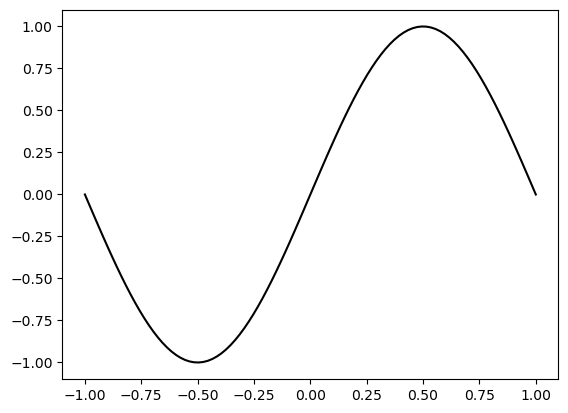

In [39]:
# plot
plt.style.use('default')
plt.figure()

plt.plot(x_t,reall,'k')
plt.plot(x_t,prediction,'r')
plt.plot(x_t,prediction+3*sigma,'b')
plt.scatter(X_know[0:2],f_know[0:2])
plt.scatter(X_know[2:-1],f_know[2:-1])

plt.legend([ 'Ground truth','Prediction','Prediction bounds','Boundary points','Collocation points'], loc = 'best') 
plt.plot(x_t,prediction-3*sigma,'b')